# Library

In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from collections import Counter


# Fungsi Ekstraksi Fitur MFCC

In [2]:
def extract_mfcc(file_path, n_mfcc=40, max_len=100):
    """
    Ekstrak MFCC dari file audio.
    Params:
        file_path: path ke file audio
        n_mfcc: jumlah koefisien MFCC
        max_len: panjang maksimal frame MFCC (padding/truncating)
    Returns:
        mfcc: numpy array shape (n_mfcc, max_len)
    """
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    
    # Padding atau truncating agar panjang fixed
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
        
    return mfcc


# Load Dataset, Ekstrak Fitur dan Label

In [3]:
def load_dataset(dataset_path):
    features = []
    labels = []
    
    classes = os.listdir(dataset_path)
    print("Detected classes:", classes)
    
    for label in classes:
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav') or filename.endswith('.mp3'):
                file_path = os.path.join(class_dir, filename)
                mfcc = extract_mfcc(file_path)
                features.append(mfcc)
                labels.append(label)
                print(mfcc)
    
    return np.array(features), np.array(labels)


#  Persiapan Dataset untuk Training

In [ ]:
dataset_path = "/Users/farizajyputra/Documents/tugas_dicoding/Capstone/ML/Project-crysense-preprocessing-main/augmented_dataset" # folder dataset kamu
X, y = load_dataset(dataset_path)

print("Feature shape:", X.shape) 

# Encode label string ke integer
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Ubah label ke one-hot encoding
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

# CNN expect input dengan channel => tambah dimensi channel (1)
X = X[..., np.newaxis]

X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")


Detected classes: ['silence', 'Discomfort', 'Burping', 'noise', 'Cold-Hot', 'Hungry', 'Belly Pain', 'laugh']
[[-1.09845192e+02 -1.26350861e+02 -1.50197601e+02 ... -1.32008667e+02
  -1.27059929e+02 -1.29778458e+02]
 [ 1.16441666e+02  1.19570450e+02  1.18319962e+02 ...  1.30125854e+02
   1.29939377e+02  1.20451897e+02]
 [ 1.83348236e+01  2.48371277e+01  3.03416576e+01 ...  2.99416714e+01
   2.27225723e+01  2.36625824e+01]
 ...
 [-3.54771644e-01 -1.03716826e+00  6.26677632e-01 ...  5.55863857e+00
   4.00406456e+00  3.61675978e+00]
 [-6.17939353e-01 -7.36358702e-01  8.67257893e-01 ...  1.36092365e+00
  -1.04839551e+00  1.19406915e+00]
 [ 2.05681157e+00  1.31587088e-02  2.41712332e-02 ... -3.09716272e+00
  -2.04128695e+00  2.17618179e+00]]
[[-294.60553    -291.8845     -296.74088    ... -329.82117
  -329.58997    -332.21854   ]
 [ 111.28248     110.957825    112.006226   ...   98.344604
    97.86314      96.841156  ]
 [  25.85165      33.18831      30.412937   ...   40.99567
    44.851913  

# Bangun Model CNN Klasifikasi Audio

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers


model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

optimizer = SGD(learning_rate=0.0001, momentum=0.9)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,688 (5.83 MB)

 Trainable params: 1,527,496 (5.83 MB)

 Non-trainable params: 192 (768.00 B)

# Pelatihan Model

In [6]:
history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(X_val, y_val))


Epoch 1/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2572 - loss: 4.7797 - val_accuracy: 0.4018 - val_loss: 2.5045
Epoch 2/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3833 - loss: 3.9290 - val_accuracy: 0.4916 - val_loss: 1.9629
Epoch 3/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4161 - loss: 3.6026 - val_accuracy: 0.5168 - val_loss: 1.8726
Epoch 4/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4422 - loss: 3.3918 - val_accuracy: 0.5336 - val_loss: 1.7869
Epoch 5/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4670 - loss: 3.1459 - val_accuracy: 0.5503 - val_loss: 1.7590
Epoch 6/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4793 - loss: 3.0159 - val_accuracy: 0.5587 - val_loss: 1.7032
Epoch 7/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4989 - loss: 2.8604 - val_accuracy: 0.5646 - val_loss: 1.6582
Epoch 8/40
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5173 - loss: 2.5757 - val_accuracy: 0.5822 - v

# Evaluasi Model

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7088 - loss: 1.0226
Test accuracy: 0.7075


# Prediksi dan Interpretasi Hasil

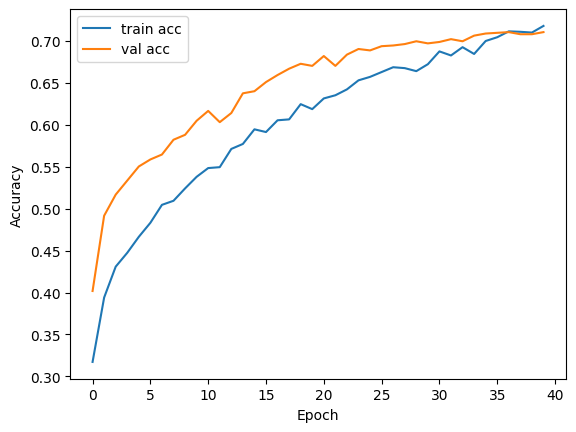

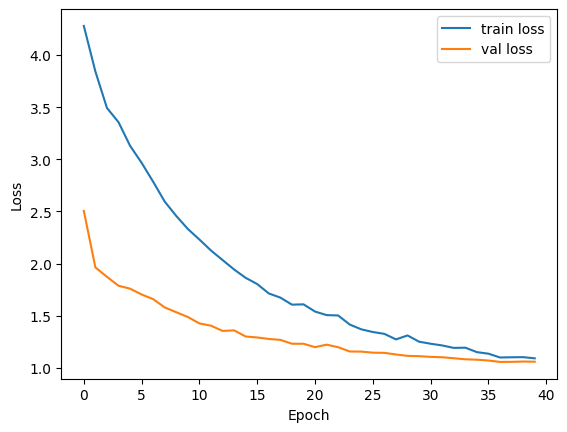

In [8]:
import matplotlib.pyplot as plt

# Plot akurasi selama training
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss selama training
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
model.save('model_crysense.h5')

# Pengetesan Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model = keras.models.load_model('model_crysense.h5')

print("Model berhasil dimuat!")
model.summary()

Model berhasil dimuat!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,690 (5.83 MB)

 Trainable params: 1,527,496 (5.83 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
model.export("saved_model_dir")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_dir")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Simpan model TFLite
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model_dir/assets


INFO:tensorflow:Assets written to: saved_model_dir/assets


Saved artifact at 'saved_model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 100, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  16445129296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445134400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445196416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445197472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445142144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445144608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445210320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445208384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445328016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445327840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  16445328544: TensorSpec(shape=(), dtype=tf.resource, name

W0000 00:00:1748364796.417937  506821 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1748364796.417945  506821 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,690 (5.83 MB)

 Trainable params: 1,527,496 (5.83 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

signal, sr = librosa.load("/Users/farizajyputra/Documents/tugas_dicoding/Capstone/ML/Project-crysense-preprocessing-main/augmented_dataset/Belly Pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp (1)_aug208_pitch.wav", sr=22050)

mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=98)
mfcc = mfcc[:,:38]
mfcc = mfcc.T 

mfcc_input = mfcc[..., np.newaxis] 
mfcc_input = np.expand_dims(mfcc_input, axis=0)

model = load_model("model_crysense.h5")
pred = model.predict(mfcc_input)

# Interpretasi hasil (misal klasifikasi 8 kelas)
# ['Silence', 'Discomfort', 'Burping', 'noise', 'Cold-Hot', 'Hungry', 'Belly Pain', 'laugh']
predicted_class = np.argmax(pred)
print("Prediksi kelas:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Prediksi kelas: 6
